### Importing libraries and dataset

In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

import warnings
warnings.simplefilter(action='ignore')

In [2]:
wine_dataset = load_wine()
df = pd.DataFrame(wine_dataset.data, columns=wine_dataset.feature_names)
df['target'] = wine_dataset['target']
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [3]:
df.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline', 'target'],
      dtype='object')

### Functions to plot data, compute accuracy and pick the best model

In [4]:
def plot_data_boundaries(X, y, model, parameters, title, axes_labels, n_cols=1, n_rows=1, show_support_vectors=False, single_title_appendix=None ):
    # function for visualizing data and the decision boundaries
    # X, y: arrays data
    # model: string indicating the model 
    # parameters: array of parameters in order to create different plots. In the case of RBFKernelBest it is the model 
    # title: title of the entire set of figures
    # single_title_appendix: the appendix of the sub-title below every figure
    # axes_labels: labels for the x and y axes
    
    if model != "model":
        n_figures = len(parameters)
        #fig, axs = plt.subplots(n_cols, n_rows, figsize=(5*n_cols,5*n_rows))
        fig = plt.figure(figsize=(5*n_cols,5*n_rows))
        fig.suptitle(title)
        
        fig.set_dpi(100)
    else:
        plt.plot(dpi = 100)
        plt.title(title)
        
    cmap = ListedColormap(['plum', 'blueviolet', 'darkslateblue'])
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    if model == "model":
        #parameters.fit(X, y)
        Z = parameters.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor='k', s=20)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xlabel=axes_labels[0]
        plt.ylabel=axes_labels[1]
        return
    
        #fig = plt.figure(figsize=(12,12))
        #for index, name in enumerate(names):
        #ax = fig.add_subplot(4,6,index+1)
    for index, k in enumerate(parameters):
        if model == "KNN":
            KNN = KNeighborsClassifier(n_neighbors=k)
            KNN.fit(X, y)
            Z = KNN.predict(np.c_[xx.ravel(), yy.ravel()])
        elif model == "LinearSVM":
            SVM = SVC(C=k, kernel= 'linear')
            SVM.fit(X, y)
            Z = SVM.predict(np.c_[xx.ravel(), yy.ravel()])
        elif model =="RBFKernel":
            SVM = SVC(C=k)
            SVM.fit(X, y)
            Z = SVM.predict(np.c_[xx.ravel(), yy.ravel()])
            
        Z = Z.reshape(xx.shape)
        index_row = int(index/n_rows)
        index_col = index%n_rows
        #axs[index_row][index_col].pcolormesh(xx, yy, Z, cmap=cmap)
        #axs[index_row][index_col].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor='k', s=20)
        
        axs = fig.add_subplot(n_rows, n_cols, index+1)
        axs.pcolormesh(xx, yy, Z, cmap=cmap)
        axs.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor='k', s=20)
        if model != "KNN" and show_support_vectors==True:
            support_vectors = SVM.support_vectors_
            axs.scatter(support_vectors[:, 0], support_vectors[:, 1], marker='*', c='white', alpha=0.5, s=40)
        axs.set_xlim(xx.min(), xx.max())
        axs.set_ylim(yy.min(), yy.max())
        axs.set_title("%s = %s" % (single_title_appendix, k))
        axs.set(xlabel=axes_labels[0], ylabel=axes_labels[1])
        
def print_accuracy_report(X_train, y_train, X_test, y_test, model, parameter_name, parameters=None):
    accuracy_array = np.zeros(len(parameters))
    for index, k in enumerate(parameters):
        if model == "KNN":
            KNN = KNeighborsClassifier(n_neighbors=k)
            KNN.fit(X_train, y_train)
            y_pred = KNN.predict(X_test)
        elif model == "LinearSVM":
            SVM = SVC(C=k, kernel='linear')
            SVM.fit(X_train, y_train)
            y_pred = SVM.predict(X_test)
        elif model =="RBFKernel":
            SVM_RBF_kernel = SVC(C=k)
            SVM_RBF_kernel.fit(X_train, y_train)
            y_pred = SVM_RBF_kernel.predict(X_test)
        elif model =="model":
            SVM_RBF_kernel_best = SVC(parameters)
            SVM_RBF_kernel_best.fit(X_train, y_train)
            y_pred = SVM_RBF_kernel.predict(X_test)
            
            
        accuracy_array[index] = accuracy_score(y_test, y_pred)

    data = pd.DataFrame({parameter_name: parameters, 'Accuracy':accuracy_array})
    plt.figure(dpi = 100)
    x_min, x_max = parameters.min(), parameters.max()
    y_min, y_max = accuracy_array.min(), accuracy_array.max()
    plt.title("Accuracy scores with different values of %s" % parameter_name)
    plt.xlabel("Value of %s" % parameter_name)
    plt.ylabel("Accuracy score")
    plt.scatter(parameters, accuracy_array) #, '--bo')
    best_parameter = data[data.Accuracy == data.Accuracy.max()][parameter_name].values[0]
    if model != "KNN":
        plt.xscale('symlog')
    plt.ylim(accuracy_array.min() - 0.03 , accuracy_array.max()+ 0.03)
    plt.show()
    return data, best_parameter


### Plotting the data

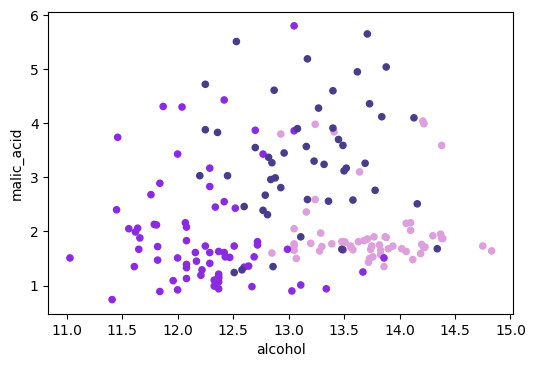

In [5]:
data = df[['alcohol', 'malic_acid', 'target']]
colors = {0:'plum', 1:'blueviolet', 2:'darkslateblue'}
plt.rcParams["figure.dpi"] = 100
data.plot(kind='scatter', x="alcohol", y="malic_acid", c= df['target'].apply(lambda x: colors[x]))

In [8]:
data = df.groupby('target').size()
data

target
0    59
1    71
2    48
dtype: int64

Text(0, 0.5, 'Number of wines ')

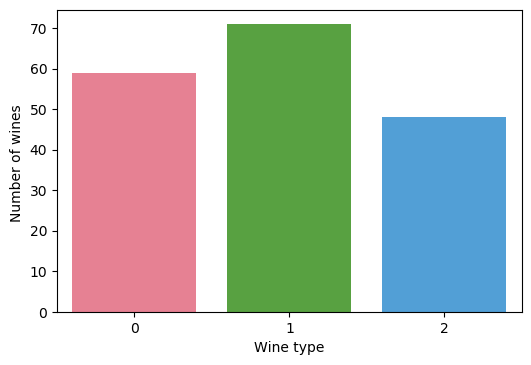

In [9]:
sns.barplot([0, 1, 2], data, palette = "husl")
plt.xlabel('Wine type')
plt.ylabel('Number of wines ')

### Dividing the data in train, validation and test set

In [6]:
X = data[['alcohol', 'malic_acid']].values
y = data['target'].values

In [7]:
X_train_val, X_test, y_train_val, y_test  = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.33, random_state=1)

### K-Nearest Neighbors applications for different values of K

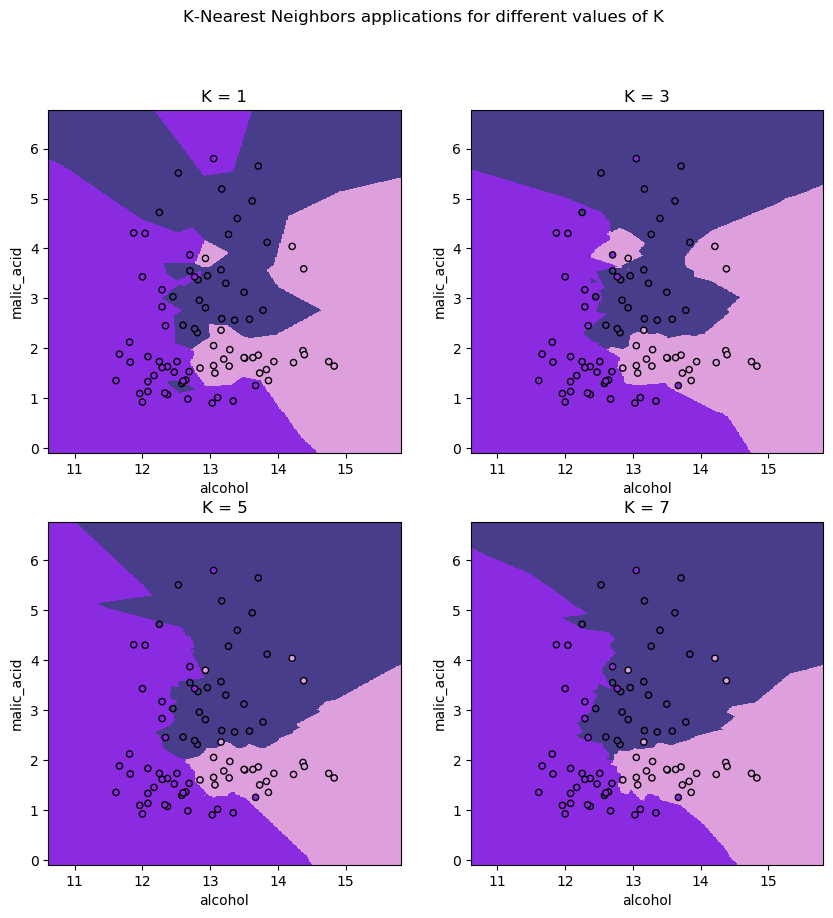

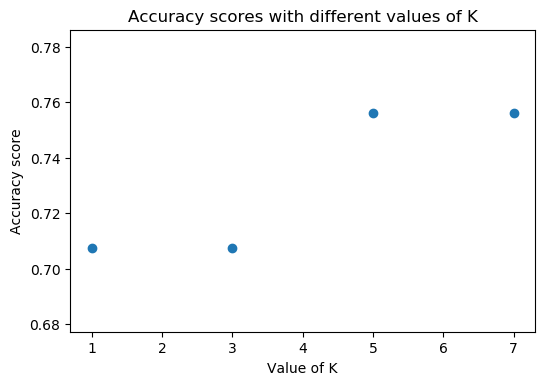

In [8]:
K = np.array([1, 3, 5, 7])
plot_data_boundaries(X_train, y_train, "KNN", 
                     K, 'K-Nearest Neighbors applications for different values of K',
                     ['alcohol', 'malic_acid'], 2, 2, False, "K")

table, best_k = print_accuracy_report(X_train, y_train, X_val, y_val, "KNN", "K", K)

In [9]:
table.head()

,K,Accuracy
0,1,0.707317
1,3,0.707317
2,5,0.756098
3,7,0.756098


In [10]:
KNN = KNeighborsClassifier(n_neighbors=best_k)
KNN.fit(X_train_val, y_train_val)
y_pred = KNN.predict(X_test)
print("Accuracy score for the best value K = %s: %.5s" % (best_k, accuracy_score(y_test, y_pred)))

Accuracy score for the best value K = 5: 0.814


### Linear SVM application for different values of C

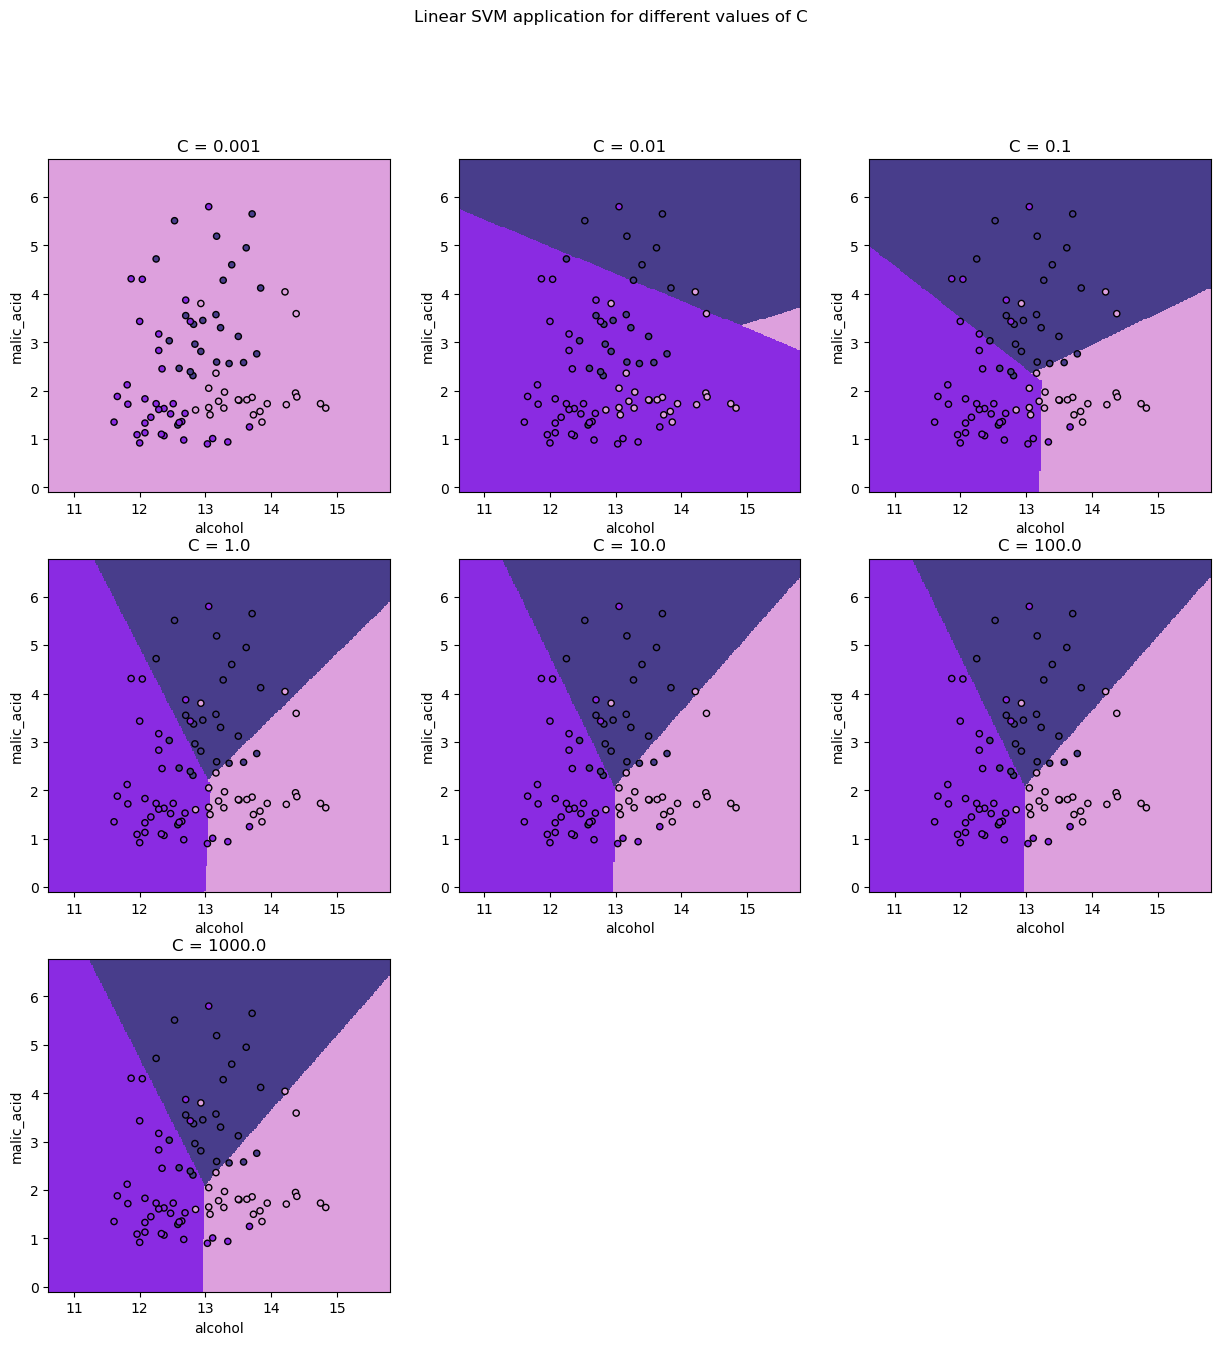

In [11]:
C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
plot_data_boundaries(X_train, y_train, "LinearSVM", 
                     C, 'Linear SVM application for different values of C',
                    ['alcohol', 'malic_acid'], 3, 3, False, "C")

### Linear SVM application for different values of C with standardized data

In [12]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

X_train_val_s = scaler.fit_transform(X_train_val)
X_test_s = scaler.transform(X_test)

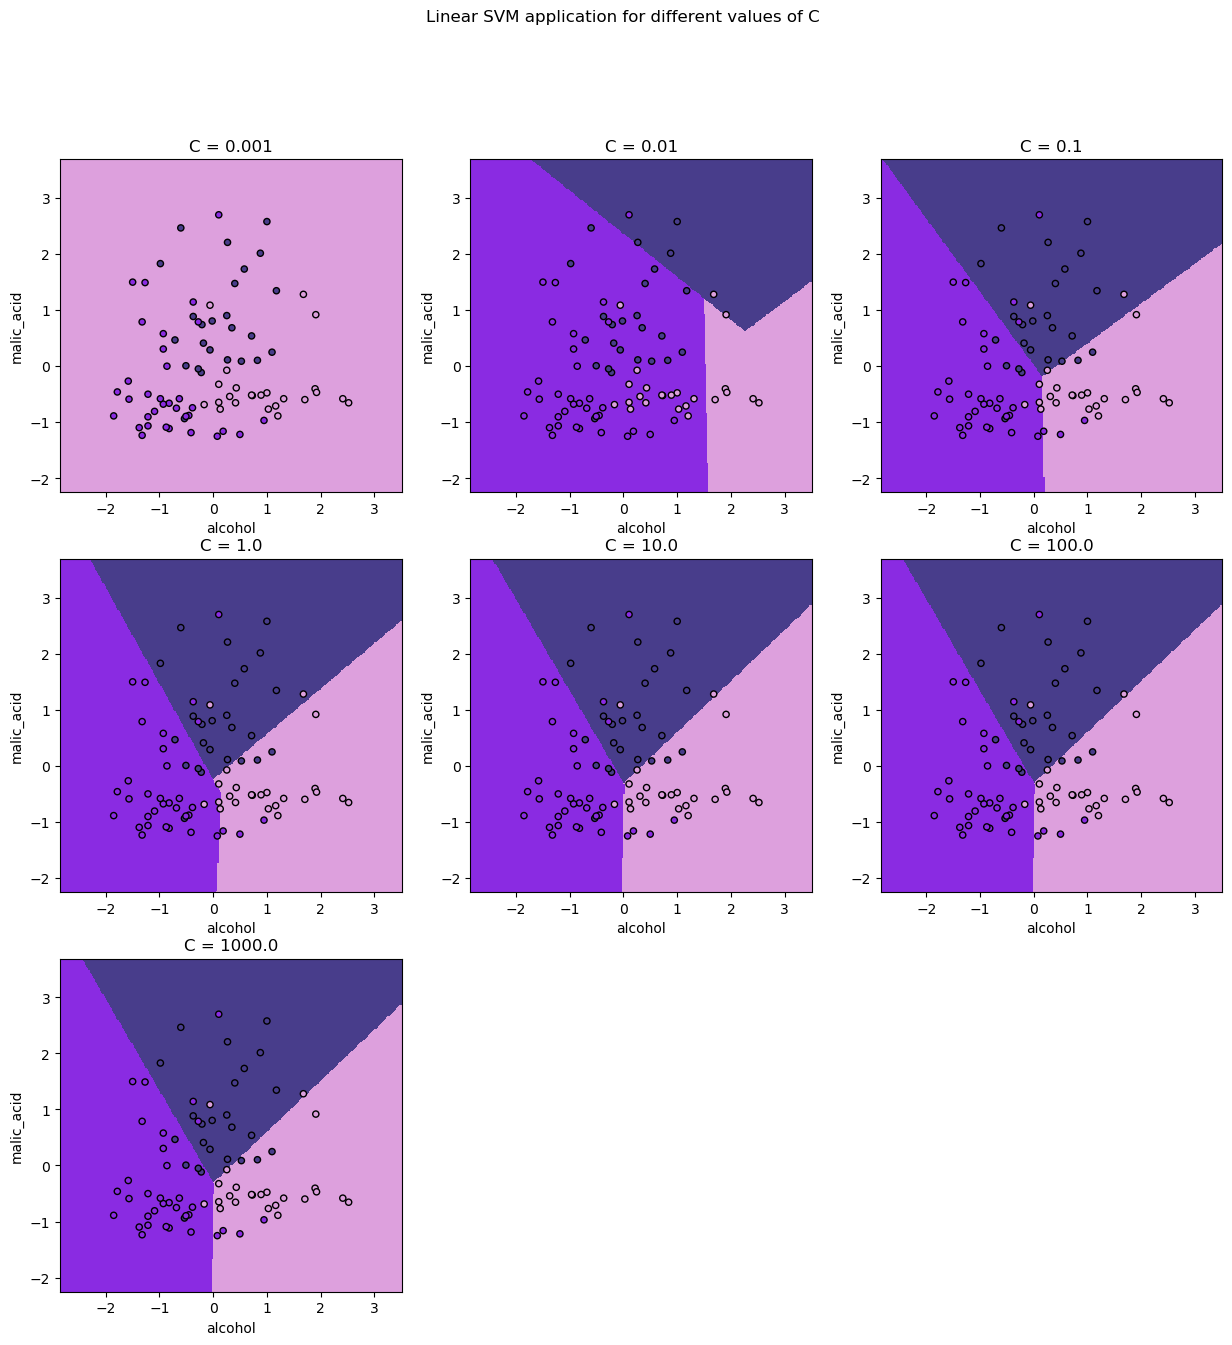

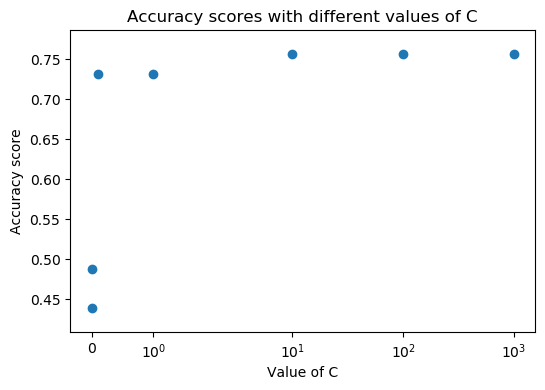

In [13]:
plot_data_boundaries(X_train_s, y_train, "LinearSVM", 
                     C, 'Linear SVM application for different values of C',
                     ['alcohol', 'malic_acid'], 3, 3, False, "C")

table, best_C = print_accuracy_report(X_train_s, y_train, X_val_s, y_val, "LinearSVM", "C", C)

In [14]:
table

,C,Accuracy
0,0.001,0.439024
1,0.010,0.487805
2,0.100,0.731707
3,1.000,0.731707
4,10.000,0.756098
5,100.000,0.756098
6,1000.000,0.756098


In [15]:
SVM = LinearSVC(C=best_C)
SVM.fit(X_train_val_s, y_train_val)
y_pred = SVM.predict(X_test_s)
print("Accuracy score for the best value C = %s: %.5s" % (best_C, accuracy_score(y_test, y_pred)))

Accuracy score for the best value C = 10.0: 0.851


### SVM with RBF kernel application for different values of C

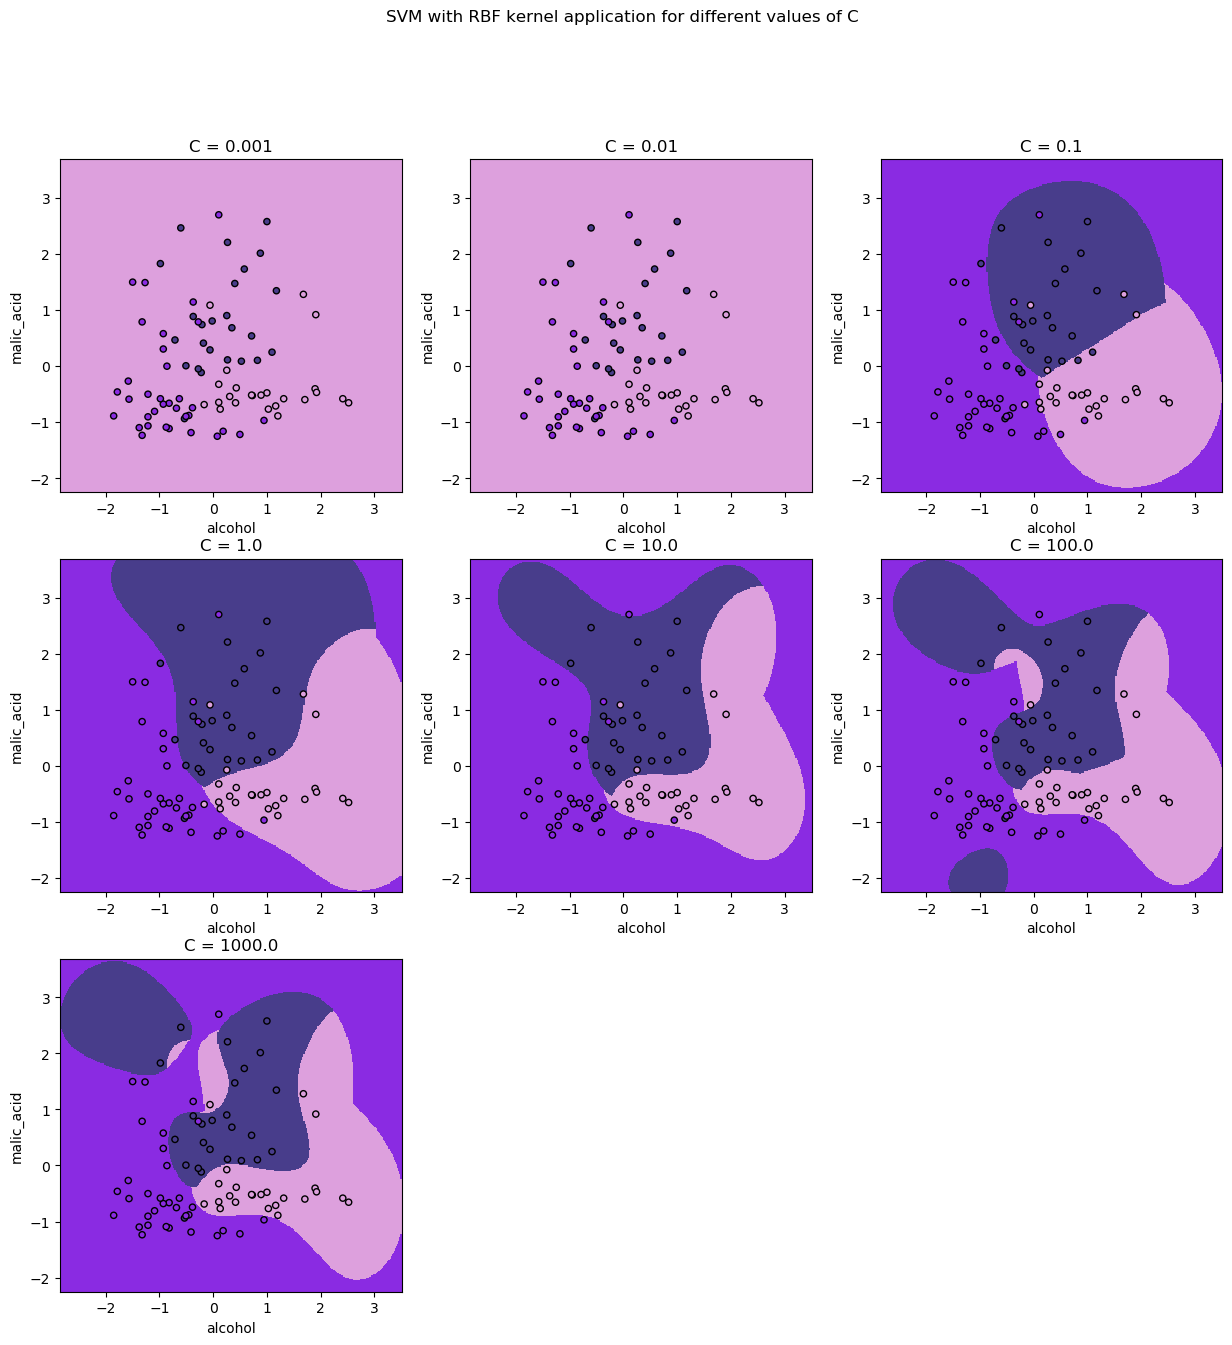

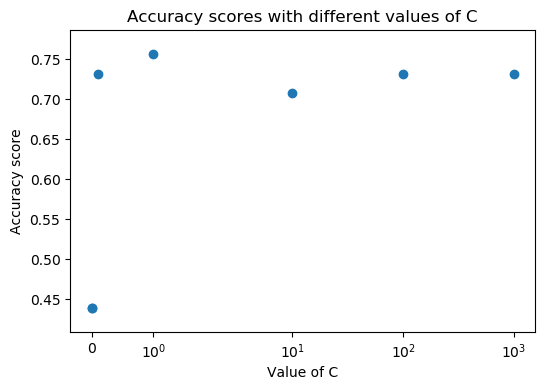

In [16]:
C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
plot_data_boundaries(X_train_s, y_train, "RBFKernel", 
                     C, 'SVM with RBF kernel application for different values of C',
                     ['alcohol', 'malic_acid'], 3, 3, False, "C")

table, best_C = print_accuracy_report(X_train_s, y_train, X_val_s, y_val, "RBFKernel", "C", C)

In [17]:
table

,C,Accuracy
0,0.001,0.439024
1,0.010,0.439024
2,0.100,0.731707
3,1.000,0.756098
4,10.000,0.707317
5,100.000,0.731707
6,1000.000,0.731707


In [18]:
svc_rbf = SVC(C=best_C)
svc_rbf.fit(X_train_val_s, y_train_val)
y_pred = svc_rbf.predict(X_test_s)
print("Accuracy score for the best value C = %s: %.5s" % (best_C, accuracy_score(y_test, y_pred)))

Accuracy score for the best value C = 1.0: 0.833


### Grid search for tuning the parameters gamma and C for SVM with RBF Kernel using train data

Best model:
{'C': 100, 'gamma': 1}


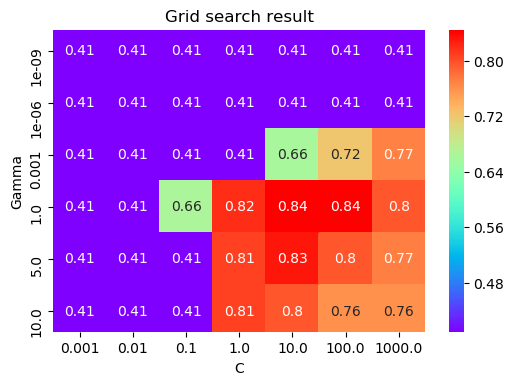

In [19]:
parameters = {'gamma':[1e-9, 1e-6, 1e-3, 1, 5, 10],
 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svc = SVC()
model = GridSearchCV(svc, parameters)
model.fit(X_train_s, y_train)
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_), values='mean_test_score', index='param_gamma', columns='param_C')
axes = sns.heatmap(pvt, annot = True, cmap='rainbow')
axes.set_xlabel('C')
axes.set_ylabel('Gamma')
bottom, top = axes.get_ylim()
axes.set_ylim(bottom + 0.4, top - 0.4)
axes.set_title("Grid search result")
best_model_train = model.best_estimator_
print("Best model:")
print(model.best_params_)

Accuracy score for the best configuration {'C': 100, 'gamma': 1}: 0.814


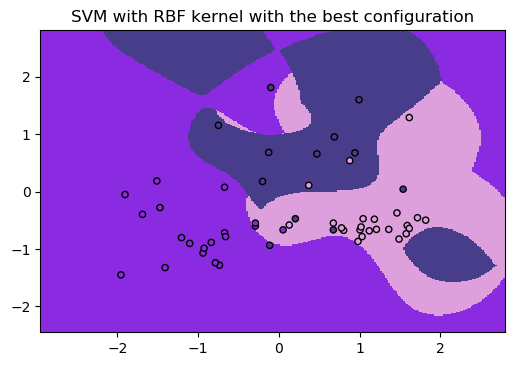

In [20]:
best_svm_t = SVC(**model.best_params_)
best_svm_t.fit(X_train_val_s, y_train_val)
plot_data_boundaries(X_test_s, y_test, "model", best_svm_t, 'SVM with RBF kernel with the best configuration', ['alcohol', 'malic_acid'])
#best_svm_t.fit(X_train_val_s, y_train_val)
y_pred = best_svm_t.predict(X_test_s)
print("Accuracy score for the best configuration %s: %.5s" % (model.best_params_, accuracy_score(y_test, y_pred)))

### Grid search for tuning the parameters gamma and C for SVM with RBF Kernel using train and validation data

Best model:
{'C': 1, 'gamma': 1}


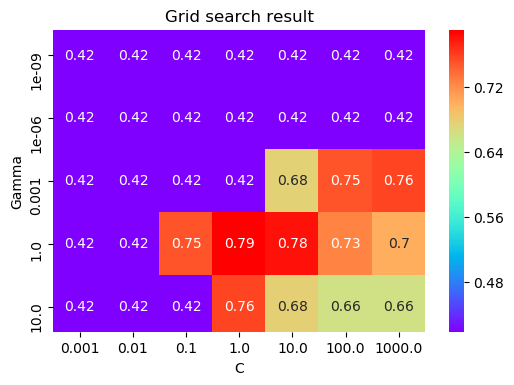

In [21]:
parameters = {'gamma':[1e-9, 1e-6, 1e-3, 1, 10],
 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svc = SVC()
model = GridSearchCV(svc, parameters) #default 5-fold validation
model.fit(X_train_val_s, y_train_val)
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_), values='mean_test_score', index='param_gamma', columns='param_C')
axes = sns.heatmap(pvt, annot = True, cmap='rainbow')
axes.set_xlabel('C')
axes.set_ylabel('Gamma')
bottom, top = axes.get_ylim()
axes.set_ylim(bottom + 0.4, top - 0.4)
axes.set_title("Grid search result")
best_model_train_val = model.best_estimator_
print("Best model:")
print(model.best_params_)

Accuracy score for the best configuration {'C': 1, 'gamma': 1}: 0.833


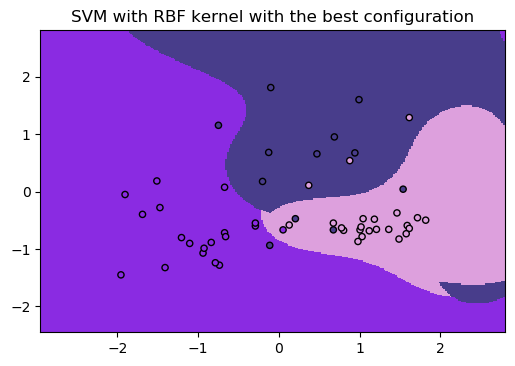

In [22]:
best_svm_tv = SVC(**model.best_params_)
best_svm_tv.fit(X_train_val_s, y_train_val)
plot_data_boundaries(X_test_s, y_test, "model", best_svm_tv, 'SVM with RBF kernel with the best configuration', ['alcohol', 'malic_acid'])
y_pred = best_svm_tv.predict(X_test_s)
print("Accuracy score for the best configuration %s: %.5s" % (model.best_params_, accuracy_score(y_test, y_pred)))

### Extracting the best 2 feautures from the dataset using ExtraTreesClassifier

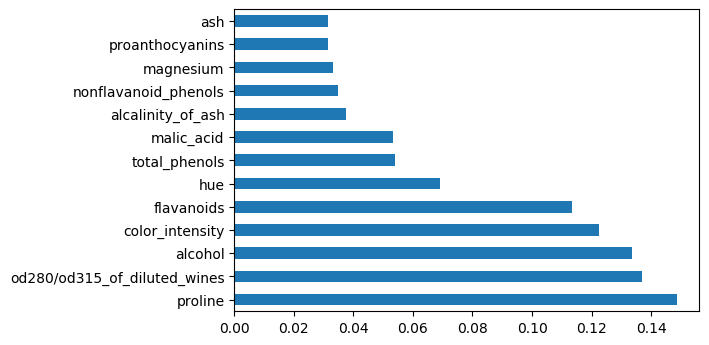

In [23]:
X = df.iloc[:,0:13]  
y = df.iloc[:,-1]    
model = ExtraTreesClassifier()
model.fit(X,y) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh')
plt.show()

In [24]:
X = df[['flavanoids', 'proline']].values
y = df['target'].values

In [25]:
X_train_val, X_test, y_train_val, y_test  = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.33, random_state=1)

In [26]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

X_train_val_s = scaler.fit_transform(X_train_val)
X_test_s = scaler.transform(X_test)

### Test 1: KNN

In [27]:
parameters = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15]}
knn = KNeighborsClassifier()
model = GridSearchCV(knn, parameters)
model.fit(X_train_val_s, y_train_val)
best_model_train = model.best_estimator_
print("Best model:")
print(model.best_params_)

Best model:
{'n_neighbors': 5}


Accuracy score for KNN {'n_neighbors': 5}: 0.888


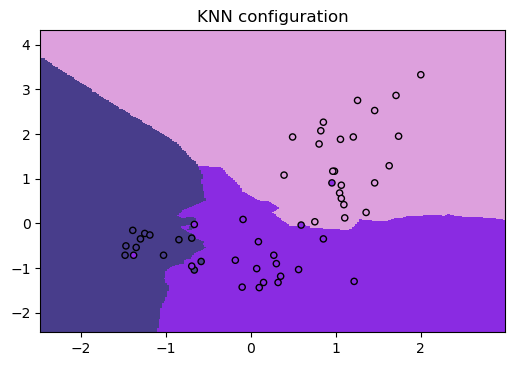

In [28]:
best_knn = KNeighborsClassifier(**model.best_params_)
best_knn.fit(X_train_val_s, y_train_val)
plot_data_boundaries(X_test_s, y_test, "model", best_knn, 'KNN configuration', ['flavanoids', 'proline'])

y_pred = best_knn.predict(X_test_s)
print("Accuracy score for KNN %s: %.5s" % (model.best_params_, accuracy_score(y_test, y_pred)))

### Test 2: SVM with RBF Kernel

In [29]:
parameters = {'gamma':[1e-9, 1e-6, 1e-3, 1, 10],
 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svc = SVC()
model = GridSearchCV(svc, parameters) #default 5-fold validation
model.fit(X_train_val_s, y_train_val)
best_model_train_val = model.best_estimator_
print("Best model:")
print(model.best_params_)

Best model:
{'C': 10, 'gamma': 1}


Accuracy score for RBF kernel {'C': 10, 'gamma': 1}: 0.907


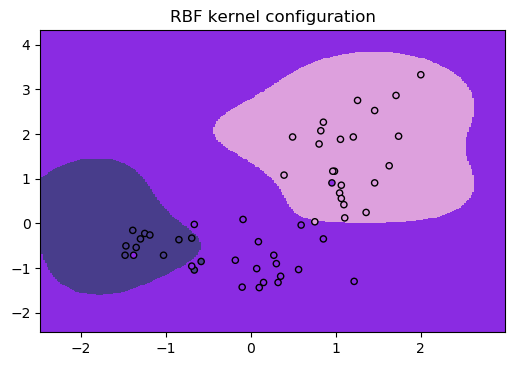

In [30]:
best_svm_rbf = SVC(**model.best_params_)
best_svm_rbf.fit(X_train_val_s, y_train_val)
plot_data_boundaries(X_test_s, y_test, "model", best_svm_rbf, 'RBF kernel configuration', ['flavanoids', 'proline'])
y_pred = best_svm_rbf.predict(X_test_s)
print("Accuracy score for RBF kernel %s: %.5s" % (model.best_params_, accuracy_score(y_test, y_pred)))